# Solving the Buffer-Stock Model with Deep Learning

## 1. Imports

In [2]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE' # without this Python may crash when plotting from matplotlib
import numpy as np
import torch 
import matplotlib.pyplot as plt
import EconDLSolvers
from dynamic_programming.BufferStockModelEGM import BufferStockModelEGMClass

## 2. Model

We are going to solve a **simple buffer-stock model**.

1. Two states: cash-on-hand $m_t$ and persistent income $p_t$
2. Two shocks $\psi_t \sim \log \mathcal{N}\left(-\frac{1}{2}\sigma_{\psi}^2,\sigma_{\psi}^2\right)$, and $\xi_t \sim \log \mathcal{N}\left(-\frac{1}{2}\sigma_{\xi}^2,\sigma_{\xi^2}\right)$
3. A single choice: consumption $c_t$, or equivalently the savings rate, $a_t\in[0,1]$

The utility function is

$$
u(c_t) = \log (c_t)
$$

The bellman equation is

$$
\begin{align}
v_t(m_t,p_t) &= \underset{s_t\in[0,1]}{\max} \ u(c_t) + \beta \mathbb{E}_t[v_{t+1}(m_{t+1},p_{t+1})] \\
&\text{s.t}  \nonumber \\
c_t &= (1-s_t) m_t\\ 
\overline{b}_t &= m_t - c_t = m_t s_t\\ 
p_{t+1}&=p_t^{\rho} \xi_{t+1} \\
m_{t+1} &= (1+r) \overline{b}_t + p_{t+1}\psi_{t+1} 
\end{align}
$$

## 3. Defining the model class

First define the model class based on the **DLSolverclass** from the package.

In [3]:
class Model(EconDLSolvers.DLSolverClass): # inherit from DLSolverClass

    # setup and allocate
    def setup(self): pass
    def allocate(self): pass
    def setup_train(self): pass
    def allocate_train(self): pass

    # draw
    def draw_initial_states(self): pass
    def draw_shocks(self): pass

    # transition
    def outcomes(self): pass # states, actions -> (intermediary) outcomes
    def state_trans_pd(self): pass # states, actions, outcomes -> post-decision states
    def state_trans(self): pass # post-decision states, shocks -> next-period states
    def terminal_actions(self): pass # action in last period = zero savings rate = consume everything

    # reward
    def reward(self): pass # utility
    terminal_reward_pd = EconDLSolvers.terminal_reward_pd # default is just 0
    discount_factor = EconDLSolvers.discount_factor # default is just par.beta

### 3.1. Setup and allocate

In [4]:
def setup(model):
    """ choose parameters """

    # unpack
    par = model.par
    sim = model.sim

    par.seed = 1 # seed for random number generator

    # model parameters
    par.T = 5 # number of periods
    par.beta = 1.0/1.04 # discount factor
    par.r = 0.02 # return rate

    # income process
    par.sigma_psi = 0.3 # std of transitory shock
    par.sigma_xi = 0.1 # std of persistent shock
    par.rho_p = 0.95 # persistence of persistent shock

    # initial states
    par.mu_m0 = 1.0 # mean of initial cash-on-hand
    par.sigma_m0 = 0.1 # std of initial cash-on-hand

    par.mu_p0 = 1.0 # mean of initial persistent productivity
    par.sigma_p0 = 0.1 # std of initial persistent productivity

    # miscellaneous
    par.Nstates = 2 # number of states (m,p)
    par.Nstates_pd = 2 # number of states, post decision (b,p)
    par.Nactions = 1 # number of actions -> savings rate   
    par.Noutcomes = 1 # consumption 
    par.Nshocks = 2 # psi and xi 
    sim.N = 100_000 # number of agents

Model.setup = setup

In [5]:
def allocate(model):
    """ allocate arrays  """

    par = model.par
    sim = model.sim
    train = model.train
    dtype = train.dtype
    device = train.device        

    # simulation 
    sim.states = torch.zeros((par.T,sim.N,par.Nstates),dtype=dtype,device=device) # state-vector
    sim.states_pd = torch.zeros((par.T,sim.N,par.Nstates_pd),dtype=dtype,device=device) # post-decision state vector
    sim.shocks = torch.zeros((par.T,sim.N,par.Nshocks),dtype=dtype,device=device) # shock-vector
    sim.outcomes = torch.zeros((par.T,sim.N,par.Noutcomes),dtype=dtype,device=device) # outcomes array
    sim.actions = torch.zeros((par.T,sim.N,par.Nactions),dtype=dtype,device=device)  # actions array
    sim.reward = torch.zeros((par.T,sim.N),dtype=dtype,device=device) # array for utility rewards

    sim.R = np.nan # initialize average discounted utility

Model.allocate = allocate

In [6]:
def setup_train(model):
    """ default parameters for training """
    
    par = model.par
    train = model.train
    dtype = train.dtype
    device = train.device

    # neural network
    train.Nneurons_policy = np.array([50,50]) # number of neurons in hidden layers
    
    # policy activation functions and clipping
    train.policy_activation_final = ['sigmoid'] # choice variable between 0 and 1 
    train.min_actions = torch.tensor([0.0],dtype=dtype,device=device) # minimum action value
    train.max_actions = torch.tensor([0.9999],dtype=dtype,device=device) # maximum action value		

Model.setup_train = setup_train

In [7]:
def allocate_train(model):
    """ allocate memory training """

    par = model.par
    train = model.train
    dtype = train.dtype
    device = train.device

    train.states = torch.zeros((par.T,train.N,par.Nstates),dtype=dtype,device=device)
    train.states_pd = torch.zeros((par.T,train.N,par.Nstates_pd),dtype=dtype,device=device)
    train.shocks = torch.zeros((par.T,train.N,par.Nshocks),dtype=dtype,device=device)
    train.outcomes = torch.zeros((par.T,train.N,par.Noutcomes),dtype=dtype,device=device)
    train.actions = torch.zeros((par.T,train.N,par.Nactions),dtype=dtype,device=device)
    train.reward = torch.zeros((par.T,train.N),dtype=dtype,device=device)

Model.allocate_train = allocate_train

### 3.2. Drawing shocks and initial states

In [8]:
def draw_initial_states(model,N,training=False):
    """ draw initial state (m,p,t) """
 
    par = model.par
    
    # draw initial cash-on-hand
    m0 = par.mu_m0*torch.exp(torch.normal(-0.5*par.sigma_m0**2,par.sigma_m0,size=(N,)))
    
    # draw permanent income
    p0 = par.mu_p0*torch.exp(torch.normal(-0.5*par.sigma_p0**2,par.sigma_p0,size=(N,)))
 
    return torch.stack((m0,p0),dim=1) # (N,Nstates)

def draw_shocks(model,N):
    """ draw shocks """

    par = model.par

    xi = torch.normal(0.0,1.0,size=(par.T,N))
    xi = torch.exp(par.sigma_xi*xi-0.5*par.sigma_xi**2) # adjustment for log-normal

    psi = torch.normal(0.0,1.0,size=(par.T,N))
    psi = torch.exp(par.sigma_psi*psi-0.5*par.sigma_psi**2) # adjustment for log-normal
    return torch.stack((xi,psi),dim=-1) # (T,N,Nshocks)

Model.draw_initial_states = draw_initial_states
Model.draw_shocks = draw_shocks

### 3.3 Transition function

In [9]:
def outcomes(model,states,actions,t0=0,t=None):
	""" outcomes """

	m = states[...,0]
	s = actions[...,0]
	c = m*(1-s) # equation 2 

	return torch.stack((c,),dim=-1) # (T,N,Noutcomes)

Model.outcomes = outcomes

In [10]:
def state_trans_pd(model,states,actions,outcomes,t0=0,t=None):
	""" transition to post-decision state """
	
	m = states[...,0] # cash-on-hand
	p = states[...,1] # persistent income
	c = outcomes[...,0] # consumption
	b_pd = m-c # next_period wealth # equation 3

	states_pd = torch.stack((b_pd,p),dim=-1)
	return states_pd

Model.state_trans_pd = state_trans_pd

In [11]:
def state_trans(model,states_pd,shocks,t=None):
	""" state transition with quadrature """
	par = model.par

	# unpack
	b_pd = states_pd[...,0] # post-decision wealth
	p_pd = states_pd[...,1] # permanent income
	
	xi = shocks[:,0] # shock on persistent income
	psi = shocks[:,1] # transitory shock

	# transition to next-period 
	p_plus = p_pd**par.rho_p*xi # equation 4
	m_plus = (1+par.r)*b_pd + p_plus * psi # equation 5
	
	states_plus = torch.stack((m_plus,p_plus),dim=-1) 
	return states_plus

Model.state_trans = state_trans

In [12]:
def reward(model,states,actions,outcomes,t0=0,t=None):
	""" reward """

	c = outcomes[...,0]
	u = torch.log(c)

	return u 

Model.reward = reward

### 4. Solve the model

In [13]:
device = 'cpu' # EconDLSolvers.choose_gpu()
model_DeepSimulate = Model(algoname='DeepSimulate',device=device, train={'K_time': 0.5}) # K_time is the time dedicated to training, but you can stop the algorithm at any time by setting "terminate": true in the solving.json file
model_DeepSimulate.solve(do_print=True)

started solving: 2025-05-19 10:10:11
k =     0 of inf: sim.R =  -1.08369124 [best:  -1.08369124] [0.1 secs] [value_epochs =   0] [policy_epochs =   1] [  0.00 mins]
k =    50 of inf: sim.R =  -0.35012883 [best:  -0.35012883] [0.0 secs] [value_epochs =   0] [policy_epochs =   1] [  0.01 mins]
k =   100 of inf: sim.R =  -0.23877640 [best:  -0.23877640] [0.0 secs] [value_epochs =   0] [policy_epochs =   1] [  0.01 mins]
k =   150 of inf: sim.R =  -0.22895110 [best:  -0.22895110] [0.0 secs] [value_epochs =   0] [policy_epochs =   1] [  0.02 mins]
k =   200 of inf: sim.R =  -0.22465676 [best:  -0.22465676] [0.0 secs] [value_epochs =   0] [policy_epochs =   1] [  0.03 mins]
k =   250 of inf: sim.R =  -0.21709789 [best:  -0.21709789] [0.0 secs] [value_epochs =   0] [policy_epochs =   1] [  0.03 mins]
k =   300 of inf: sim.R =  -0.19962147 [best:  -0.19962147] [0.0 secs] [value_epochs =   0] [policy_epochs =   1] [  0.04 mins]
k =   350 of inf: sim.R =  -0.17692243 [best:  -0.17692243] [0.0 se

To compare our solution, we also solve the same model with the endogenous grid method

In [14]:
dp = BufferStockModelEGMClass(name='DP')
dp.solve_EGM()
dp.simulate_R()
print(dp.sim.R)

-0.16749737587500668


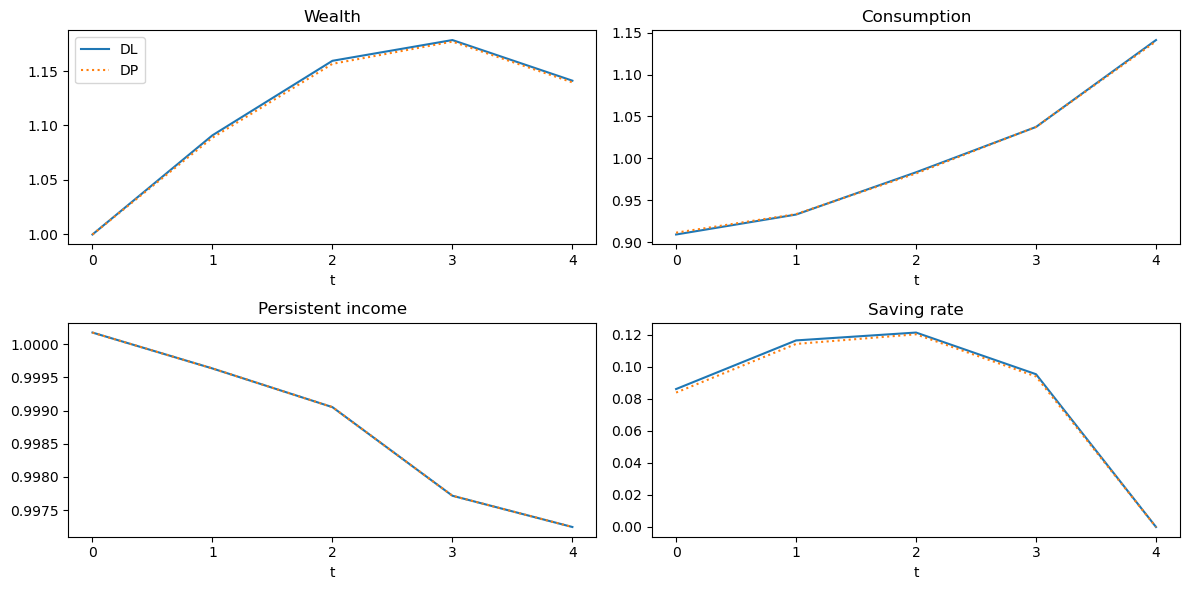

In [16]:
t_range = range(model_DeepSimulate.par.T)
coh_dl = model_DeepSimulate.sim.states[...,0].mean(dim=1).cpu().numpy()
consumption_dl = model_DeepSimulate.sim.outcomes[...,0].mean(dim=1).cpu().numpy()

coh_dp = dp.sim.states[...,0].mean(axis=1)
consumption_dp = dp.sim.outcomes[...,0].mean(axis=1)

fig, ax = plt.subplots(2,2,figsize=(12,6))

ax[0,0].plot(t_range,coh_dl,label='DL')
ax[0,0].plot(t_range,coh_dp,label='DP', linestyle = ':')
ax[0,0].set_xlabel('t')
ax[0,0].set_xticks(t_range)
ax[0,0].legend()
ax[0,0].set_title('Wealth')

ax[0,1].plot(t_range,consumption_dl,label='DL')
ax[0,1].plot(t_range,consumption_dp,label='DP', linestyle = ':')
ax[0,1].set_xlabel('t')
ax[0,1].set_xticks(t_range)
ax[0,1].set_title('Consumption')

ax[1,0].plot(t_range,model_DeepSimulate.sim.states[:,:,1].mean(dim=1).cpu().numpy(),label='DL')
ax[1,0].plot(t_range,dp.sim.states[:,:,1].mean(axis=1),label='DL', linestyle = ':')
ax[1,0].set_xlabel('t')
ax[1,0].set_xticks(t_range)
ax[1,0].set_title('Persistent income')

ax[1,1].plot(t_range,model_DeepSimulate.sim.actions[:,:,0].mean(dim=1).cpu().numpy(),label='DL')
ax[1,1].plot(t_range,dp.sim.actions[:,:,0].mean(axis=1),label='DL', linestyle = ':')
ax[1,1].set_xlabel('t')
ax[1,1].set_xticks(t_range)
ax[1,1].set_title('Saving rate')


fig.tight_layout()